In [41]:
import numpy as np
import pandas as pd
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings('ignore')

# Load and clean data functions

In [2]:
df_complete = pd.read_csv('C:/Users/Cole/Documents/DATA/PLIC_DATA/Collective_Surveys/Complete/Complete_Concat.csv')
df_beta = pd.read_excel('C:/Users/Cole/Documents/DATA/PLIC_DATA/Data_from_development/Coded_FR/PLIC_beta_FR_Tim+Saaj_collapsed.xlsx').fillna(0)

def GetQColumns(df, Q, suffix = ''):
    df_temp = df.loc[:, [col for col in df.columns if ((Q in col) & (('_' + suffix) in col) & ('l' not in col))]]
    other_col = [col for col in df_temp.columns if 'TEXT' in col][0].split('_')[1]
    df_temp = df_temp.loc[:, [col for col in df_temp.columns if other_col not in col]]
    return df_temp

def GetNewResponses(df, Q):
    def GetPrePost(df, suffix):
        df_temp = df.loc[df['Survey_' + suffix] == 'F', :]
        df_temp = GetQColumns(df_temp, Q, suffix)
        df_temp = df_temp.dropna(subset = [col for col in df_temp.columns if col != (Q + '_' + suffix)], how = 'all')
        df_temp.columns = [col[:-2] for col in df_temp.columns]
        return df_temp
        
    df_pre = GetPrePost(df, 'x')
    df_post = GetPrePost(df, 'y')
    return pd.concat([df_pre, df_post], axis = 0).reset_index(drop = True).fillna(0)

def GetOldResponses(df, Q, collapse = True, reset = True):
    df_temp = df.loc[:, [col for col in df.columns if Q in col]]
    
    if collapse:
        cols = list(set(['_'.join(col.split('_')[:2]) for col in df_temp.columns if '_' in col]))
        cols = [col.replace('.1', '') for col in cols]
        for col_new in cols:
            df_temp[col_new] = 1 * (df_temp.loc[:, [col for col in df_temp.columns[1:] if 
                                                    col_new.split('_')[-1] == col.split('_')[1]]].sum(axis = 1) > 0)
    else:
        cols = ['_'.join(col.split('_')[:2]).replace('.1', '') for col in df_temp.columns if '_' in col]
        df_temp.columns = [Q] + cols
    
    if reset:
        df_temp = df_temp.loc[df_temp[cols].sum(axis = 1) > 0, :]
        cols.append(Q)
        return df_temp[cols].reset_index(drop = True)
    else:
        cols.append(Q)
        return df_temp[cols]
    
def GetAllData(df_old, df_new, Q):
    df_old = GetOldResponses(df_old, Q)
    df_new = GetNewResponses(df_new, Q)
    return pd.concat([df_old, df_new], axis = 0, join = 'outer').loc[:, list(df_new.columns)].reset_index(drop = True).sample(frac = 1, random_state = 11).reset_index(drop = True)

def CompareHumans(Q, who, cols = None):
    if(who == 'NH'):
        df_nh = pd.read_excel('C:/Users/Cole/Documents/DATA/PLIC_DATA/Coded_OR/NH/Comparison_Set_NH.xlsx', skiprows = [1])
        df_cw_small = pd.read_excel('C:/Users/Cole/Documents/DATA/PLIC_DATA/Coded_OR/CW/Comparison_Set_CW.xlsx', skiprows = [1])

        df_nh = GetQColumns(df_nh, Q).notnull().astype(int)
        df_cw_small = GetQColumns(df_cw_small, Q).notnull().astype(int)
        rows = (df_nh.sum(axis = 1) > 0) & (df_cw_small.sum(axis = 1) > 0)
        df_nh = df_nh.loc[rows, :]
        df_cw_small = df_cw_small.loc[rows, :]
        
        return df_nh, df_cw_small
    else:
        df_undergrads = pd.read_excel('C:/Users/Cole/Documents/DATA/PLIC_DATA/Data_from_development/Coded_FR/PLIC_beta_FR_Tim+Saaj_collapsed.xlsx').fillna(0)
        df_cw_large = pd.read_excel('C:/Users/Cole/Documents/DATA/PLIC_DATA/Data_from_development/Coded_FR/PLIC_beta_FR_CW_collapsed.xlsx', skiprows = [1]).fillna(0)
        df_undergrads = GetOldResponses(df_undergrads, Q, False, False).loc[:, cols]
        df_cw_large = GetOldResponses(df_cw_large, Q, True, False).loc[:, cols]
        rows = (df_undergrads.sum(axis = 1) > 0) & (df_cw_large.sum(axis = 1) > 0)
        df_undergrads = df_undergrads.loc[rows, :]
        df_cw_large = df_cw_large.loc[rows, :]
        
        return df_undergrads, df_cw_large

# ML pipeline

In [12]:
Scoring = 'f1'
CV = 5

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        Tokenizer = RegexpTokenizer(r'\w+|%|\+|\-')
        return [self.wnl.lemmatize(t) for t in Tokenizer.tokenize(doc)]
    
class StemTokenizer(object):
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        Tokenizer = RegexpTokenizer(r'\w+|%|\+|\-')
        return [self.ps.stem(t) for t in Tokenizer.tokenize(doc)]

def CodeFR(df, Q, Scoring, CV, alg):
    steps = [('TFIDF', TfidfVectorizer(stop_words = 'english', tokenizer = StemTokenizer(), ngram_range = (1, 2), 
                                       max_features = 1000))]
    if alg == 'SVM':
        steps.append(('SVM', SVC(kernel = 'linear', random_state = 11, class_weight = 'balanced')))
        Params = {
            'SVM__C': (0.001, 0.01, 0.1, 1)
        }
    elif alg == 'NB':
        steps.append(('NB', MultinomialNB()))
        Params = {
            'NB__alpha': (0.001, 0.01, 0.1, 1)
        }
    else:
        steps.append(('Logit', LogisticRegression(random_state = 11, class_weight = 'balanced')))
        Params = {
            'Logit__C': (0.001, 0.01, 0.1, 1)
        }                           
    Pipe = Pipeline(steps)

    Grid_Search = GridSearchCV(Pipe, Params, n_jobs = 1, verbose = 1, cv = CV, scoring = Scoring)

    X = df[Q].astype(str).fillna('')
    y = df.drop(Q, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

    df_new1, df_new2 = CompareHumans(Q, 'NH')
    df_old1, df_old2 = CompareHumans(Q, 'undergrads', [Q] + list(y_train.columns))
    
    F1_scores_ML = []
    F1_scores_NH = []
    F1_scores_Undergrads = []
    drop_cols = []
    counts = []
    fracs = []
    for col in y_train.columns:
        na_rows_train = np.array(np.isnan(y_train[col]))
        if y_train[col].nunique() < 2:
            drop_cols.append(col)
            continue
        Grid_Search.fit(X_train[~na_rows_train], y_train.loc[~na_rows_train, col])
        
        na_rows_test = np.array(np.isnan(y_test[col]))
        y_pred = Grid_Search.predict(X_test[~na_rows_test])

        print(col)
        counts.append(sum(y[col]))
        fracs.append(sum(y[col])/len(y))
        
        print('\nML\n')
        print(metrics.confusion_matrix(y_test.loc[~na_rows_test, col], y_pred))
        F1_scores_ML.append(metrics.f1_score(y_test.loc[~na_rows_test, col], y_pred))
        
        print('\nNH\n')
        try:
            print(metrics.confusion_matrix(df_new1.loc[:, col], df_new2.loc[:, col]))
            F1_scores_NH.append(metrics.f1_score(df_new1.loc[:, col], df_new2.loc[:, col]))
        except:
            F1_scores_NH.append(None)
        
        if(Q in ['Q1b', 'Q1d', 'Q1e']):
            print('\nUndergrads\n')
            try:
                print(metrics.confusion_matrix(df_old1.loc[:, col], df_old2.loc[:, col]))
                F1_scores_Undergrads.append(metrics.f1_score(df_old1.loc[:, col], df_old2.loc[:, col]))
            except:
                F1_scores_Undergrads.append(None)
    if Q in ['Q1b', 'Q1d', 'Q1e']:
        return pd.DataFrame({'Q': y_train.drop(columns = drop_cols).columns, 'ML': F1_scores_ML, 'NH': F1_scores_NH, 
                             'Undergrads': F1_scores_Undergrads, 'Count':counts, 'Frac':fracs})
    else:
        return pd.DataFrame({'Q': y_train.drop(columns = drop_cols).columns, 'ML': F1_scores_ML, 'NH': F1_scores_NH, 
                             'Count':counts, 'Frac':fracs})      

# Question Q1B

In [13]:
df_1b = GetAllData(df_beta, df_complete, 'Q1b')
logitdf_1b = CodeFR(df_1b, 'Q1b', Scoring, CV, 'Logit').rename(columns = {'ML':'Logit'})
svmdf_1b = CodeFR(df_1b, 'Q1b', Scoring, CV, 'SVM').rename(columns = {'ML':'SVM'})
bayesdf_1b = CodeFR(df_1b, 'Q1b', Scoring, CV, 'NB').rename(columns = {'ML':'Bayes'})
dfML_1b = pd.merge(logitdf_1b, svmdf_1b, on = ['Q', 'Undergrads', 'NH', 'Count', 
                                               'Frac']).merge(bayesdf_1b, on = ['Q', 'Undergrads', 'NH', 'Count', 'Frac'])
dfML_1b

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.0s finished


Q1b_16

ML

[[133   5]
 [  3  11]]

NH

[[48  0]
 [ 1  0]]

Undergrads

[[417   3]
 [  5  28]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q1b_28

ML

[[109  15]
 [ 15  13]]

NH

[[31  2]
 [ 5 11]]

Undergrads

[[392  19]
 [  9  33]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q1b_2

ML

[[73 19]
 [11 49]]

NH

[[33  6]
 [ 5  5]]

Undergrads

[[200  17]
 [ 19 217]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.4s finished


Q1b_31

ML

[[134  11]
 [  0   7]]

NH

[[47  1]
 [ 0  1]]

Undergrads

[[394  12]
 [  3  44]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q1b_5

ML

[[68 15]
 [14 55]]

NH

[[19  2]
 [ 2 26]]

Undergrads

[[237   9]
 [ 14 193]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q1b_8

ML

[[137   2]
 [  3  10]]

NH

[[44  0]
 [ 1  4]]

Undergrads

[[412   0]
 [  2  39]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q1b_16

ML

[[134   4]
 [  4  10]]

NH

[[48  0]
 [ 1  0]]

Undergrads

[[417   3]
 [  5  28]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.6s finished


Q1b_28

ML

[[111  13]
 [ 12  16]]

NH

[[31  2]
 [ 5 11]]

Undergrads

[[392  19]
 [  9  33]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q1b_2

ML

[[75 17]
 [14 46]]

NH

[[33  6]
 [ 5  5]]

Undergrads

[[200  17]
 [ 19 217]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.0s finished


Q1b_31

ML

[[139   6]
 [  0   7]]

NH

[[47  1]
 [ 0  1]]

Undergrads

[[394  12]
 [  3  44]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q1b_5

ML

[[69 14]
 [15 54]]

NH

[[19  2]
 [ 2 26]]

Undergrads

[[237   9]
 [ 14 193]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q1b_8

ML

[[136   3]
 [  2  11]]

NH

[[44  0]
 [ 1  4]]

Undergrads

[[412   0]
 [  2  39]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q1b_16

ML

[[138   0]
 [ 12   2]]

NH

[[48  0]
 [ 1  0]]

Undergrads

[[417   3]
 [  5  28]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q1b_28

ML

[[120   4]
 [ 25   3]]

NH

[[31  2]
 [ 5 11]]

Undergrads

[[392  19]
 [  9  33]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q1b_2

ML

[[73 19]
 [14 46]]

NH

[[33  6]
 [ 5  5]]

Undergrads

[[200  17]
 [ 19 217]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.5s finished


Q1b_31

ML

[[144   1]
 [  4   3]]

NH

[[47  1]
 [ 0  1]]

Undergrads

[[394  12]
 [  3  44]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q1b_5

ML

[[68 15]
 [19 50]]

NH

[[19  2]
 [ 2 26]]

Undergrads

[[237   9]
 [ 14 193]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.7s finished


Q1b_8

ML

[[137   2]
 [  9   4]]

NH

[[44  0]
 [ 1  4]]

Undergrads

[[412   0]
 [  2  39]]


,Q,Logit,NH,Undergrads,Count,Frac,SVM,Bayes
0,Q1b_16,0.733333,0.000000,0.875000,54.0,0.071334,0.714286,0.250000
1,Q1b_28,0.464286,0.758621,0.702128,111.0,0.146631,0.561404,0.171429
2,Q1b_2,0.765625,0.476190,0.923404,347.0,0.458388,0.747967,0.736000
3,Q1b_31,0.560000,0.666667,0.854369,60.0,0.079260,0.700000,0.545455
4,Q1b_5,0.791367,0.928571,0.943765,328.0,0.433289,0.788321,0.746269
5,Q1b_8,0.800000,0.888889,0.975000,72.0,0.095112,0.814815,0.421053


# Question Q1D

In [14]:
df_1d = GetAllData(df_beta, df_complete, 'Q1d')
logitdf_1d = CodeFR(df_1d, 'Q1d', Scoring, CV, 'Logit').rename(columns = {'ML':'Logit'})
svmdf_1d = CodeFR(df_1d, 'Q1d', Scoring, CV, 'SVM').rename(columns = {'ML':'SVM'})
bayesdf_1d = CodeFR(df_1d, 'Q1d', Scoring, CV, 'NB').rename(columns = {'ML':'Bayes'})
dfML_1d = pd.merge(logitdf_1d, svmdf_1d, on = ['Q', 'Undergrads', 'NH', 'Count', 
                                               'Frac']).merge(bayesdf_1d, on = ['Q', 'Undergrads', 'NH', 'Count', 'Frac'])
dfML_1d

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.4s finished


Q1d_1

ML

[[63 13]
 [10 48]]

NH

[[21  0]
 [ 1 21]]

Undergrads

[[36  1]
 [ 3 34]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.2s finished


Q1d_3

ML

[[83  9]
 [11 31]]

NH

[[33  0]
 [ 1  9]]

Undergrads

[[39  0]
 [ 3 32]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q1d_51

ML

[[121   8]
 [  3   2]]

NH

[[40  0]
 [ 2  1]]

Undergrads

[[67  1]
 [ 5  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q1d_53

ML

[[105  11]
 [  8  10]]

NH

[[39  1]
 [ 0  3]]

Undergrads

[[62  2]
 [ 6  4]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q1d_55

ML

[[121   3]
 [  3   7]]

NH

[[38  0]
 [ 1  4]]

Undergrads

[[66  1]
 [ 1  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q1d_57

ML

[[110  10]
 [  4  10]]

NH

[[40  2]
 [ 0  1]]

Undergrads

[[61  1]
 [ 2 10]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q1d_59

ML

[[111  12]
 [  5   6]]

NH

[[38  0]
 [ 2  3]]

Undergrads

[[40 21]
 [ 5  8]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q1d_5

ML

[[98  7]
 [ 6 23]]

NH

[[26  1]
 [ 1 15]]

Undergrads

[[56  0]
 [ 2 16]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q1d_61

ML

[[121   8]
 [  5   0]]

NH

[[43]]

Undergrads

[[66  1]
 [ 5  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q1d_63

ML

[[93 22]
 [ 8 11]]

NH

[[39  1]
 [ 1  2]]

Undergrads

[[64  3]
 [ 4  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q1d_1

ML

[[60 16]
 [10 48]]

NH

[[21  0]
 [ 1 21]]

Undergrads

[[36  1]
 [ 3 34]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q1d_3

ML

[[85  7]
 [12 30]]

NH

[[33  0]
 [ 1  9]]

Undergrads

[[39  0]
 [ 3 32]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q1d_51

ML

[[122   7]
 [  3   2]]

NH

[[40  0]
 [ 2  1]]

Undergrads

[[67  1]
 [ 5  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q1d_53

ML

[[105  11]
 [ 11   7]]

NH

[[39  1]
 [ 0  3]]

Undergrads

[[62  2]
 [ 6  4]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q1d_55

ML

[[123   1]
 [  4   6]]

NH

[[38  0]
 [ 1  4]]

Undergrads

[[66  1]
 [ 1  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.9s finished


Q1d_57

ML

[[114   6]
 [  7   7]]

NH

[[40  2]
 [ 0  1]]

Undergrads

[[61  1]
 [ 2 10]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q1d_59

ML

[[117   6]
 [  5   6]]

NH

[[38  0]
 [ 2  3]]

Undergrads

[[40 21]
 [ 5  8]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.1s finished


Q1d_5

ML

[[98  7]
 [ 5 24]]

NH

[[26  1]
 [ 1 15]]

Undergrads

[[56  0]
 [ 2 16]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.0s finished


Q1d_61

ML

[[117  12]
 [  4   1]]

NH

[[43]]

Undergrads

[[66  1]
 [ 5  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q1d_63

ML

[[85 30]
 [ 7 12]]

NH

[[39  1]
 [ 1  2]]

Undergrads

[[64  3]
 [ 4  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q1d_1

ML

[[56 20]
 [14 44]]

NH

[[21  0]
 [ 1 21]]

Undergrads

[[36  1]
 [ 3 34]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q1d_3

ML

[[89  3]
 [16 26]]

NH

[[33  0]
 [ 1  9]]

Undergrads

[[39  0]
 [ 3 32]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q1d_51

ML

[[129   0]
 [  5   0]]

NH

[[40  0]
 [ 2  1]]

Undergrads

[[67  1]
 [ 5  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q1d_53

ML

[[116   0]
 [ 16   2]]

NH

[[39  1]
 [ 0  3]]

Undergrads

[[62  2]
 [ 6  4]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q1d_55

ML

[[124   0]
 [  8   2]]

NH

[[38  0]
 [ 1  4]]

Undergrads

[[66  1]
 [ 1  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.6s finished


Q1d_57

ML

[[118   2]
 [ 12   2]]

NH

[[40  2]
 [ 0  1]]

Undergrads

[[61  1]
 [ 2 10]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q1d_59

ML

[[122   1]
 [ 11   0]]

NH

[[38  0]
 [ 2  3]]

Undergrads

[[40 21]
 [ 5  8]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q1d_5

ML

[[95 10]
 [ 7 22]]

NH

[[26  1]
 [ 1 15]]

Undergrads

[[56  0]
 [ 2 16]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q1d_61

ML

[[129   0]
 [  5   0]]

NH

[[43]]

Undergrads

[[66  1]
 [ 5  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q1d_63

ML

[[112   3]
 [ 14   5]]

NH

[[39  1]
 [ 1  2]]

Undergrads

[[64  3]
 [ 4  3]]


,Q,Logit,NH,Undergrads,Count,Frac,SVM,Bayes
0,Q1d_1,0.806723,0.976744,0.944444,289.0,0.433934,0.786885,0.721311
1,Q1d_3,0.756098,0.947368,0.955224,222.0,0.333333,0.759494,0.732394
2,Q1d_51,0.266667,0.500000,0.250000,34.0,0.051051,0.285714,0.000000
3,Q1d_53,0.512821,0.857143,0.500000,101.0,0.151652,0.388889,0.200000
4,Q1d_55,0.700000,0.888889,0.857143,56.0,0.084084,0.705882,0.333333
5,Q1d_57,0.588235,0.500000,0.869565,56.0,0.084084,0.518519,0.222222
6,Q1d_59,0.413793,0.750000,0.380952,52.0,0.078078,0.521739,0.000000
7,Q1d_5,0.779661,0.937500,0.941176,184.0,0.276276,0.800000,0.721311
8,Q1d_61,0.000000,0.000000,0.400000,39.0,0.058559,0.111111,0.000000
9,Q1d_63,0.423077,0.666667,0.461538,99.0,0.148649,0.393443,0.370370


# Question Q1E

In [15]:
df_1e = GetAllData(df_beta, df_complete, 'Q1e')
logitdf_1e = CodeFR(df_1e, 'Q1e', Scoring, CV, 'Logit').rename(columns = {'ML':'Logit'})
svmdf_1e = CodeFR(df_1e, 'Q1e', Scoring, CV, 'SVM').rename(columns = {'ML':'SVM'})
bayesdf_1e = CodeFR(df_1e, 'Q1e', Scoring, CV, 'NB').rename(columns = {'ML':'Bayes'})
dfML_1e = pd.merge(logitdf_1e, svmdf_1e, on = ['Q', 'Undergrads', 'NH', 'Count', 
                                               'Frac']).merge(bayesdf_1e, on = ['Q', 'Undergrads', 'NH', 'Count', 'Frac'])
dfML_1e

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.6s finished


Q1e_13

ML

[[113   8]
 [  2  18]]

NH

[[45  0]
 [ 0  5]]

Undergrads

[[63  1]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.1s finished


Q1e_14

ML

[[112  14]
 [  8   7]]

NH

[[46  0]
 [ 0  4]]

Undergrads

[[54  4]
 [10  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished


Q1e_16

ML

[[132   0]
 [  3   6]]

NH

[[48  0]
 [ 0  2]]

Undergrads

[[72  0]
 [ 1  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q1e_17

ML

[[130   3]
 [  4   4]]

NH

[[50]]

Undergrads

[[71  1]
 [ 1  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished


Q1e_18

ML

[[134   3]
 [  3   1]]

NH

[[49  0]
 [ 1  0]]

Undergrads

[[72  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q1e_19

ML

[[126   7]
 [  5   3]]

NH

[[48  0]
 [ 0  2]]

Undergrads

[[67  0]
 [ 5  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.9s finished


Q1e_1

ML

[[48  8]
 [13 72]]

NH

[[15  0]
 [ 1 34]]

Undergrads

[[24  2]
 [ 4 45]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.6s finished


Q1e_20

ML

[[130   1]
 [  0  10]]

NH

[[44  0]
 [ 1  5]]

Undergrads

[[67  0]
 [ 0  8]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.6s finished


Q1e_23

ML

[[126   6]
 [  1   8]]

NH

[[47  0]
 [ 1  2]]

Undergrads

[[69  0]
 [ 1  5]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished


Q1e_24

ML

[[125  10]
 [  1   5]]

NH

[[50]]

Undergrads

[[69  0]
 [ 4  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q1e_28

ML

[[141]]

NH

[[50]]

Undergrads

[[75]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q1e_4

ML

[[120   7]
 [  4  10]]

NH

[[46  0]
 [ 0  4]]

Undergrads

[[66  2]
 [ 0  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.9s finished


Q1e_13

ML

[[114   7]
 [  2  18]]

NH

[[45  0]
 [ 0  5]]

Undergrads

[[63  1]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.3s finished


Q1e_14

ML

[[108  18]
 [  3  12]]

NH

[[46  0]
 [ 0  4]]

Undergrads

[[54  4]
 [10  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.0s finished


Q1e_16

ML

[[132   0]
 [  5   4]]

NH

[[48  0]
 [ 0  2]]

Undergrads

[[72  0]
 [ 1  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.2s finished


Q1e_17

ML

[[131   2]
 [  5   3]]

NH

[[50]]

Undergrads

[[71  1]
 [ 1  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.3s finished


Q1e_18

ML

[[134   3]
 [  3   1]]

NH

[[49  0]
 [ 1  0]]

Undergrads

[[72  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.0s finished


Q1e_19

ML

[[129   4]
 [  6   2]]

NH

[[48  0]
 [ 0  2]]

Undergrads

[[67  0]
 [ 5  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished


Q1e_1

ML

[[46 10]
 [12 73]]

NH

[[15  0]
 [ 1 34]]

Undergrads

[[24  2]
 [ 4 45]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q1e_20

ML

[[131   0]
 [  1   9]]

NH

[[44  0]
 [ 1  5]]

Undergrads

[[67  0]
 [ 0  8]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished


Q1e_23

ML

[[128   4]
 [  2   7]]

NH

[[47  0]
 [ 1  2]]

Undergrads

[[69  0]
 [ 1  5]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.5s finished


Q1e_24

ML

[[123  12]
 [  1   5]]

NH

[[50]]

Undergrads

[[69  0]
 [ 4  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.9s finished


Q1e_28

ML

[[141]]

NH

[[50]]

Undergrads

[[75]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.3s finished


Q1e_4

ML

[[124   3]
 [  4  10]]

NH

[[46  0]
 [ 0  4]]

Undergrads

[[66  2]
 [ 0  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.6s finished


Q1e_13

ML

[[118   3]
 [ 10  10]]

NH

[[45  0]
 [ 0  5]]

Undergrads

[[63  1]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.9s finished


Q1e_14

ML

[[120   6]
 [ 10   5]]

NH

[[46  0]
 [ 0  4]]

Undergrads

[[54  4]
 [10  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q1e_16

ML

[[132   0]
 [  8   1]]

NH

[[48  0]
 [ 0  2]]

Undergrads

[[72  0]
 [ 1  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s finished


Q1e_17

ML

[[132   1]
 [  6   2]]

NH

[[50]]

Undergrads

[[71  1]
 [ 1  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished


Q1e_18

ML

[[137   0]
 [  4   0]]

NH

[[49  0]
 [ 1  0]]

Undergrads

[[72  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished


Q1e_19

ML

[[130   3]
 [  8   0]]

NH

[[48  0]
 [ 0  2]]

Undergrads

[[67  0]
 [ 5  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


Q1e_1

ML

[[34 22]
 [ 5 80]]

NH

[[15  0]
 [ 1 34]]

Undergrads

[[24  2]
 [ 4 45]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.9s finished


Q1e_20

ML

[[128   3]
 [  2   8]]

NH

[[44  0]
 [ 1  5]]

Undergrads

[[67  0]
 [ 0  8]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.6s finished


Q1e_23

ML

[[130   2]
 [  2   7]]

NH

[[47  0]
 [ 1  2]]

Undergrads

[[69  0]
 [ 1  5]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.4s finished


Q1e_24

ML

[[134   1]
 [  4   2]]

NH

[[50]]

Undergrads

[[69  0]
 [ 4  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.9s finished


Q1e_28

ML

[[141]]

NH

[[50]]

Undergrads

[[75]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s finished


Q1e_4

ML

[[125   2]
 [ 11   3]]

NH

[[46  0]
 [ 0  4]]

Undergrads

[[66  2]
 [ 0  7]]


,Q,Logit,NH,Undergrads,Count,Frac,SVM,Bayes
0,Q1e_13,0.782609,1.000000,0.956522,93.0,0.132290,0.800000,0.606061
1,Q1e_14,0.388889,1.000000,0.500000,96.0,0.136558,0.533333,0.384615
2,Q1e_16,0.800000,1.000000,0.800000,32.0,0.045519,0.615385,0.200000
3,Q1e_17,0.533333,0.000000,0.666667,29.0,0.041252,0.461538,0.363636
4,Q1e_18,0.250000,0.000000,1.000000,25.0,0.035562,0.250000,0.000000
5,Q1e_19,0.333333,1.000000,0.545455,38.0,0.054054,0.285714,0.000000
6,Q1e_1,0.872727,0.985507,0.937500,403.0,0.573257,0.869048,0.855615
7,Q1e_20,0.952381,0.909091,1.000000,47.0,0.066856,0.947368,0.761905
8,Q1e_23,0.695652,0.800000,0.909091,51.0,0.072546,0.700000,0.777778
9,Q1e_24,0.476190,0.000000,0.500000,37.0,0.052632,0.434783,0.444444


# Question Q2B

In [16]:
df_2b = GetAllData(df_beta, df_complete, 'Q2b')
logitdf_2b = CodeFR(df_2b, 'Q2b', Scoring, CV, 'Logit').rename(columns = {'ML':'Logit'})
svmdf_2b = CodeFR(df_2b, 'Q2b', Scoring, CV, 'SVM').rename(columns = {'ML':'SVM'})
bayesdf_2b = CodeFR(df_2b, 'Q2b', Scoring, CV, 'NB').rename(columns = {'ML':'Bayes'})
dfML_2b = pd.merge(logitdf_2b, svmdf_2b, on = ['Q', 'NH', 'Count', 'Frac']).merge(bayesdf_2b, on = ['Q', 'NH', 'Count', 'Frac'])
dfML_2b

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.4s finished


Q2b_11

ML

[[93 24]
 [12  7]]

NH

[[34  0]
 [ 4  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q2b_1

ML

[[109  12]
 [  8   7]]

NH

[[39  2]
 [ 1  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q2b_21

ML

[[126   2]
 [  3   5]]

NH

[[43  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q2b_2

ML

[[111   8]
 [  4  13]]

NH

[[40  0]
 [ 3  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q2b_36

ML

[[110  13]
 [  7   6]]

NH

[[37  0]
 [ 2  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q2b_6

ML

[[94 11]
 [12 19]]

NH

[[32  2]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q2b_8

ML

[[46 20]
 [21 49]]

NH

[[18  3]
 [ 3 21]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.4s finished


Q2b_9

ML

[[123   2]
 [  7   4]]

NH

[[45]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.9s finished


Q2b_11

ML

[[79 38]
 [10  9]]

NH

[[34  0]
 [ 4  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q2b_1

ML

[[116   5]
 [  9   6]]

NH

[[39  2]
 [ 1  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q2b_21

ML

[[123   5]
 [  3   5]]

NH

[[43  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q2b_2

ML

[[112   7]
 [  5  12]]

NH

[[40  0]
 [ 3  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.0s finished


Q2b_36

ML

[[111  12]
 [  6   7]]

NH

[[37  0]
 [ 2  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.9s finished


Q2b_6

ML

[[93 12]
 [12 19]]

NH

[[32  2]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.3s finished


Q2b_8

ML

[[51 15]
 [22 48]]

NH

[[18  3]
 [ 3 21]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q2b_9

ML

[[124   1]
 [  8   3]]

NH

[[45]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.6s finished


Q2b_11

ML

[[114   3]
 [ 19   0]]

NH

[[34  0]
 [ 4  7]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q2b_1

ML

[[119   2]
 [ 12   3]]

NH

[[39  2]
 [ 1  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q2b_21

ML

[[128   0]
 [  5   3]]

NH

[[43  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q2b_2

ML

[[117   2]
 [ 12   5]]

NH

[[40  0]
 [ 3  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.7s finished


Q2b_36

ML

[[122   1]
 [ 13   0]]

NH

[[37  0]
 [ 2  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q2b_6

ML

[[99  6]
 [17 14]]

NH

[[32  2]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.7s finished


Q2b_8

ML

[[40 26]
 [21 49]]

NH

[[18  3]
 [ 3 21]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q2b_9

ML

[[125   0]
 [ 11   0]]

NH

[[45]]


,Q,Logit,NH,Count,Frac,SVM,Bayes
0,Q2b_11,0.280000,0.777778,77.0,0.113737,0.272727,0.000000
1,Q2b_1,0.411765,0.666667,71.0,0.104874,0.461538,0.300000
2,Q2b_21,0.666667,1.000000,71.0,0.104874,0.555556,0.545455
3,Q2b_2,0.684211,0.571429,79.0,0.116691,0.666667,0.416667
4,Q2b_36,0.375000,0.857143,71.0,0.104874,0.437500,0.000000
5,Q2b_6,0.622951,0.916667,154.0,0.227474,0.612903,0.549020
6,Q2b_8,0.705036,0.875000,359.0,0.530281,0.721805,0.675862
7,Q2b_9,0.470588,0.000000,34.0,0.050222,0.400000,0.000000


# Question Q2D

In [17]:
df_2d = GetAllData(df_beta, df_complete, 'Q2d')
logitdf_2d = CodeFR(df_2d, 'Q2d', Scoring, CV, 'Logit').rename(columns = {'ML':'Logit'})
svmdf_2d = CodeFR(df_2d, 'Q2d', Scoring, CV, 'SVM').rename(columns = {'ML':'SVM'})
bayesdf_2d = CodeFR(df_2d, 'Q2d', Scoring, CV, 'NB').rename(columns = {'ML':'Bayes'})
dfML_2d = pd.merge(logitdf_2d, svmdf_2d, on = ['Q', 'NH', 'Count', 'Frac']).merge(bayesdf_2d, on = ['Q', 'NH', 'Count', 'Frac'])
dfML_2d

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.3s finished


Q2d_21

ML

[[130   0]
 [  2   0]]

NH

[[48]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.9s finished


Q2d_23

ML

[[127   2]
 [  0   3]]

NH

[[45  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q2d_25

ML

[[117   5]
 [  3   7]]

NH

[[46  1]
 [ 1  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.5s finished


Q2d_27

ML

[[124   4]
 [  2   2]]

NH

[[44  0]
 [ 4  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.6s finished


Q2d_29

ML

[[106  11]
 [  4  11]]

NH

[[42  0]
 [ 0  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q2d_33

ML

[[72 13]
 [ 9 38]]

NH

[[32  1]
 [ 4 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q2d_35

ML

[[97 18]
 [ 8  9]]

NH

[[46  0]
 [ 1  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q2d_3

ML

[[83  7]
 [ 8 34]]

NH

[[25  2]
 [ 1 20]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q2d_4

ML

[[73 12]
 [ 9 38]]

NH

[[23  1]
 [ 1 23]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q2d_8

ML

[[119   3]
 [  1   9]]

NH

[[42  1]
 [ 0  5]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q2d_21

ML

[[130   0]
 [  2   0]]

NH

[[48]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q2d_23

ML

[[127   2]
 [  0   3]]

NH

[[45  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q2d_25

ML

[[117   5]
 [  4   6]]

NH

[[46  1]
 [ 1  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q2d_27

ML

[[119   9]
 [  2   2]]

NH

[[44  0]
 [ 4  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.9s finished


Q2d_29

ML

[[107  10]
 [  5  10]]

NH

[[42  0]
 [ 0  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.6s finished


Q2d_33

ML

[[70 15]
 [ 8 39]]

NH

[[32  1]
 [ 4 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.4s finished


Q2d_35

ML

[[87 28]
 [ 6 11]]

NH

[[46  0]
 [ 1  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q2d_3

ML

[[81  9]
 [ 9 33]]

NH

[[25  2]
 [ 1 20]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q2d_4

ML

[[73 12]
 [ 9 38]]

NH

[[23  1]
 [ 1 23]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q2d_8

ML

[[119   3]
 [  1   9]]

NH

[[42  1]
 [ 0  5]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.5s finished


Q2d_21

ML

[[130   0]
 [  2   0]]

NH

[[48]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.7s finished


Q2d_23

ML

[[129   0]
 [  2   1]]

NH

[[45  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q2d_25

ML

[[121   1]
 [ 10   0]]

NH

[[46  1]
 [ 1  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q2d_27

ML

[[128   0]
 [  4   0]]

NH

[[44  0]
 [ 4  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.3s finished


Q2d_29

ML

[[116   1]
 [ 13   2]]

NH

[[42  0]
 [ 0  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q2d_33

ML

[[72 13]
 [ 7 40]]

NH

[[32  1]
 [ 4 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.7s finished


Q2d_35

ML

[[113   2]
 [ 15   2]]

NH

[[46  0]
 [ 1  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.3s finished


Q2d_3

ML

[[81  9]
 [13 29]]

NH

[[25  2]
 [ 1 20]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.5s finished


Q2d_4

ML

[[70 15]
 [12 35]]

NH

[[23  1]
 [ 1 23]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished


Q2d_8

ML

[[122   0]
 [  6   4]]

NH

[[42  1]
 [ 0  5]]


,Q,Logit,NH,Count,Frac,SVM,Bayes
0,Q2d_21,0.000000,0.000000,4.0,0.006088,0.000000,0.000000
1,Q2d_23,0.750000,1.000000,28.0,0.042618,0.750000,0.500000
2,Q2d_25,0.636364,0.000000,52.0,0.079148,0.571429,0.000000
3,Q2d_27,0.400000,0.000000,24.0,0.036530,0.266667,0.000000
4,Q2d_29,0.594595,1.000000,70.0,0.106545,0.571429,0.222222
5,Q2d_33,0.775510,0.814815,250.0,0.380518,0.772277,0.800000
6,Q2d_35,0.409091,0.666667,80.0,0.121766,0.392857,0.190476
7,Q2d_3,0.819277,0.930233,204.0,0.310502,0.785714,0.725000
8,Q2d_4,0.783505,0.958333,243.0,0.369863,0.783505,0.721649
9,Q2d_8,0.818182,0.909091,52.0,0.079148,0.818182,0.571429


# Question Q2E

In [18]:
df_2e = GetAllData(df_beta, df_complete, 'Q2e')
logitdf_2e = CodeFR(df_2e, 'Q2e', Scoring, CV, 'Logit').rename(columns = {'ML':'Logit'})
svmdf_2e = CodeFR(df_2e, 'Q2e', Scoring, CV, 'SVM').rename(columns = {'ML':'SVM'})
bayesdf_2e = CodeFR(df_2e, 'Q2e', Scoring, CV, 'NB').rename(columns = {'ML':'Bayes'})
dfML_2e = pd.merge(logitdf_2e, svmdf_2e, on = ['Q', 'NH', 'Count', 'Frac']).merge(bayesdf_2e, on = ['Q', 'NH', 'Count', 'Frac'])
dfML_2e

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.1s finished


Q2e_12

ML

[[74  6]
 [13 36]]

NH

[[23  1]
 [ 3 15]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.1s finished


Q2e_14

ML

[[108   3]
 [  5  13]]

NH

[[36  0]
 [ 0  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q2e_15

ML

[[121   2]
 [  4   2]]

NH

[[42]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


Q2e_16

ML

[[116   6]
 [  2   5]]

NH

[[39  0]
 [ 2  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


Q2e_17

ML

[[122   2]
 [  3   2]]

NH

[[42]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.3s finished


Q2e_18

ML

[[120   3]
 [  3   3]]

NH

[[40  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


Q2e_19

ML

[[111   9]
 [  2   7]]

NH

[[36  2]
 [ 0  4]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.4s finished


Q2e_23

ML

[[107   4]
 [  8  10]]

NH

[[39  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.4s finished


Q2e_25

ML

[[114   7]
 [  5   3]]

NH

[[40  0]
 [ 2  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


Q2e_28

ML

[[128   0]
 [  1   0]]

NH

[[41  1]
 [ 0  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished


Q2e_4

ML

[[91 13]
 [13 12]]

NH

[[28  3]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s finished


Q2e_6

ML

[[120   2]
 [  2   5]]

NH

[[40  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s finished


Q2e_12

ML

[[73  7]
 [11 38]]

NH

[[23  1]
 [ 3 15]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.4s finished


Q2e_14

ML

[[110   1]
 [  7  11]]

NH

[[36  0]
 [ 0  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished


Q2e_15

ML

[[119   4]
 [  3   3]]

NH

[[42]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.6s finished


Q2e_16

ML

[[118   4]
 [  4   3]]

NH

[[39  0]
 [ 2  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s finished


Q2e_17

ML

[[123   1]
 [  3   2]]

NH

[[42]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished


Q2e_18

ML

[[120   3]
 [  3   3]]

NH

[[40  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.2s finished


Q2e_19

ML

[[112   8]
 [  2   7]]

NH

[[36  2]
 [ 0  4]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished


Q2e_23

ML

[[108   3]
 [ 10   8]]

NH

[[39  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q2e_25

ML

[[116   5]
 [  6   2]]

NH

[[40  0]
 [ 2  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q2e_28

ML

[[  0 128]
 [  0   1]]

NH

[[41  1]
 [ 0  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.3s finished


Q2e_4

ML

[[92 12]
 [12 13]]

NH

[[28  3]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.8s finished


Q2e_6

ML

[[120   2]
 [  3   4]]

NH

[[40  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.3s finished


Q2e_12

ML

[[72  8]
 [17 32]]

NH

[[23  1]
 [ 3 15]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.6s finished


Q2e_14

ML

[[111   0]
 [ 14   4]]

NH

[[36  0]
 [ 0  6]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished


Q2e_15

ML

[[122   1]
 [  6   0]]

NH

[[42]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished


Q2e_16

ML

[[122   0]
 [  7   0]]

NH

[[39  0]
 [ 2  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.6s finished


Q2e_17

ML

[[124   0]
 [  4   1]]

NH

[[42]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished


Q2e_18

ML

[[123   0]
 [  4   2]]

NH

[[40  0]
 [ 0  2]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished


Q2e_19

ML

[[117   3]
 [  6   3]]

NH

[[36  2]
 [ 0  4]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.3s finished


Q2e_23

ML

[[109   2]
 [  8  10]]

NH

[[39  0]
 [ 0  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


Q2e_25

ML

[[119   2]
 [  7   1]]

NH

[[40  0]
 [ 2  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.4s finished


Q2e_28

ML

[[128   0]
 [  1   0]]

NH

[[41  1]
 [ 0  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.1s finished


Q2e_4

ML

[[99  5]
 [17  8]]

NH

[[28  3]
 [ 0 11]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.1s finished


Q2e_6

ML

[[122   0]
 [  7   0]]

NH

[[40  0]
 [ 0  2]]


,Q,Logit,NH,Count,Frac,SVM,Bayes
0,Q2e_12,0.791209,0.882353,254.0,0.394410,0.808511,0.719101
1,Q2e_14,0.764706,1.000000,62.0,0.096273,0.733333,0.363636
2,Q2e_15,0.400000,0.000000,21.0,0.032609,0.461538,0.000000
3,Q2e_16,0.555556,0.500000,41.0,0.063665,0.428571,0.000000
4,Q2e_17,0.444444,0.000000,30.0,0.046584,0.500000,0.333333
5,Q2e_18,0.500000,1.000000,17.0,0.026398,0.500000,0.500000
6,Q2e_19,0.560000,0.800000,53.0,0.082298,0.583333,0.400000
7,Q2e_23,0.625000,1.000000,92.0,0.142857,0.551724,0.666667
8,Q2e_25,0.333333,0.000000,43.0,0.066770,0.266667,0.181818
9,Q2e_28,0.000000,0.000000,5.0,0.007764,0.015385,0.000000


# Question Q3B

In [19]:
df_3b = GetAllData(df_beta, df_complete, 'Q3b')
logitdf_3b = CodeFR(df_3b, 'Q3b', Scoring, CV, 'Logit').rename(columns = {'ML':'Logit'})
svmdf_3b = CodeFR(df_3b, 'Q3b', Scoring, CV, 'SVM').rename(columns = {'ML':'SVM'})
bayesdf_3b = CodeFR(df_3b, 'Q3b', Scoring, CV, 'NB').rename(columns = {'ML':'Bayes'})
dfML_3b = pd.merge(logitdf_3b, svmdf_3b, on = ['Q', 'NH', 'Count', 'Frac']).merge(bayesdf_3b, on = ['Q', 'NH', 'Count', 'Frac'])
dfML_3b

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.6s finished


Q3b_11

ML

[[108  15]
 [  3   2]]

NH

[[26  1]
 [ 8  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.5s finished


Q3b_1

ML

[[116   7]
 [  3   2]]

NH

[[36  1]
 [ 0  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.8s finished


Q3b_21

ML

[[125   1]
 [  1   1]]

NH

[[37  0]
 [ 1  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q3b_23

ML

[[44 13]
 [11 60]]

NH

[[19  3]
 [ 2 14]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.7s finished


Q3b_29

ML

[[109  11]
 [  4   4]]

NH

[[36  0]
 [ 1  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q3b_2

ML

[[125   0]
 [  3   0]]

NH

[[35  0]
 [ 2  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q3b_6

ML

[[84 14]
 [ 7 23]]

NH

[[23  5]
 [ 1  9]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.2s finished


Q3b_9

ML

[[74  6]
 [18 30]]

NH

[[21  0]
 [ 1 16]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q3b_11

ML

[[99 24]
 [ 2  3]]

NH

[[26  1]
 [ 8  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.8s finished


Q3b_1

ML

[[112  11]
 [  3   2]]

NH

[[36  1]
 [ 0  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished


Q3b_21

ML

[[124   2]
 [  1   1]]

NH

[[37  0]
 [ 1  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.4s finished


Q3b_23

ML

[[44 13]
 [11 60]]

NH

[[19  3]
 [ 2 14]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


Q3b_29

ML

[[116   4]
 [  5   3]]

NH

[[36  0]
 [ 1  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.0s finished


Q3b_2

ML

[[125   0]
 [  3   0]]

NH

[[35  0]
 [ 2  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.3s finished


Q3b_6

ML

[[84 14]
 [10 20]]

NH

[[23  5]
 [ 1  9]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.2s finished


Q3b_9

ML

[[76  4]
 [13 35]]

NH

[[21  0]
 [ 1 16]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q3b_11

ML

[[123   0]
 [  5   0]]

NH

[[26  1]
 [ 8  3]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q3b_1

ML

[[123   0]
 [  4   1]]

NH

[[36  1]
 [ 0  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q3b_21

ML

[[126   0]
 [  1   1]]

NH

[[37  0]
 [ 1  0]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.4s finished


Q3b_23

ML

[[35 22]
 [ 6 65]]

NH

[[19  3]
 [ 2 14]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.0s finished


Q3b_29

ML

[[117   3]
 [  8   0]]

NH

[[36  0]
 [ 1  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.6s finished


Q3b_2

ML

[[125   0]
 [  3   0]]

NH

[[35  0]
 [ 2  1]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.6s finished


Q3b_6

ML

[[94  4]
 [14 16]]

NH

[[23  5]
 [ 1  9]]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.6s finished


Q3b_9

ML

[[72  8]
 [18 30]]

NH

[[21  0]
 [ 1 16]]


,Q,Logit,NH,Count,Frac,SVM,Bayes
0,Q3b_11,0.181818,0.400000,47.0,0.073552,0.187500,0.000000
1,Q3b_1,0.285714,0.666667,31.0,0.048513,0.222222,0.333333
2,Q3b_21,0.500000,0.000000,25.0,0.039124,0.400000,0.666667
3,Q3b_23,0.833333,0.848485,349.0,0.546166,0.833333,0.822785
4,Q3b_29,0.347826,0.666667,33.0,0.051643,0.400000,0.000000
5,Q3b_2,0.000000,0.500000,11.0,0.017214,0.000000,0.000000
6,Q3b_6,0.686567,0.750000,140.0,0.219092,0.625000,0.640000
7,Q3b_9,0.714286,0.969697,254.0,0.397496,0.804598,0.697674


# Figures

## Overall difference in F-scores

66


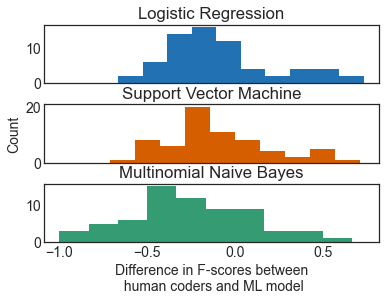

In [67]:
df_ML = pd.concat([dfML_1b, dfML_1d, dfML_1e, dfML_2b, dfML_2d, dfML_2e, dfML_3b])
df_ML['Logit-NH'] = df_ML['Logit'] - df_ML['NH']
df_ML['SVM-NH'] = df_ML['SVM'] - df_ML['NH']
df_ML['Bayes-NH'] = df_ML['Bayes'] - df_ML['NH']
print(len(df_ML))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True)
ax1.hist(df_ML['Logit-NH'], color = '#2271B2')
ax1.set_title('Logistic Regression')

ax2.hist(df_ML['SVM-NH'], color = '#D55E00')
ax2.set_title('Support Vector Machine')
ax2.set_ylabel('Count')

ax3.hist(df_ML['Bayes-NH'], color = '#359B73')
ax3.set_title('Multinomial Naive Bayes')

plt.xlabel('Difference in F-scores between\n human coders and ML model')
matplotlib.rcParams.update({'font.size': 14})
plt.subplots_adjust(hspace = 0.36)
plt.show()

## Difference in F-scores for subset

15
0.8798309260366999
0.033379428968129024
0.7669249804839416
0.016261658931668428
0.7666240840889903
0.017849765501615725
0.7242661640444521
0.01880927458997261


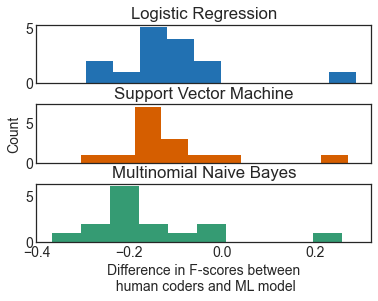

In [75]:
df_ML_sub = df_ML.loc[df_ML['Frac'] >= 0.2, :]
print(len(df_ML_sub))

print(df_ML_sub.NH.mean())
print(df_ML_sub.NH.std()/np.sqrt(len(df_ML_sub)))

print(df_ML_sub.Logit.mean())
print(df_ML_sub.Logit.std()/np.sqrt(len(df_ML_sub)))

print(df_ML_sub.SVM.mean())
print(df_ML_sub.SVM.std()/np.sqrt(len(df_ML_sub)))

print(df_ML_sub.Bayes.mean())
print(df_ML_sub.Bayes.std()/np.sqrt(len(df_ML_sub)))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True)
ax1.hist(df_ML_sub['Logit-NH'], color = '#2271B2')
ax1.set_title('Logistic Regression')

ax2.hist(df_ML_sub['SVM-NH'], color = '#D55E00')
ax2.set_title('Support Vector Machine')
ax2.set_ylabel('Count')

ax3.hist(df_ML_sub['Bayes-NH'], color = '#359B73')
ax3.set_title('Multinomial Naive Bayes')

plt.xlabel('Difference in F-scores between\n human coders and ML model')
matplotlib.rcParams.update({'font.size': 14})
plt.subplots_adjust(hspace = 0.36)
plt.show()